# City Lines Data Analysis

> This notebook was created as part of the examination requirements of "Information Structures and Implications" class offered by the Master of Digital Humanities programme in KU Leuven.

## What's this notebook about?

Often times it is thought that the complexity level of a city's transportation systems is linked to that city's level of "development". We want to investigate whether this widely-held belief holds true by interrogating the city lines dataset and combining it with other datasets which can inform us about human development. While doing this, we also want to uncover some less-known facts about metro systems such as dominant colors and crowdedness.

The questions that we will ask are as follows: 

1. Is the education level of a country related to its total railway length?
2. Is the subjective well-being of a country related to its total railway length?
3. Is personal mobile phone ownership related to the variety of transportation modes in a country?
4. Are freedom of speech rankings related to the variety of transportation modes in a country?
5. Is there a relationship in between country and the time it takes to finish the construction of a railway station?
6. Are there any “late bloomer” cities? Cities that started building up their metro system late but have quickly built up many lines and stations.
7. What are the most “crowded” (short line, lots of stations) and the most “spacious” (long line, barely no stations) lines?
8. What are some unique hues that nobody uses in coloring their metro lines?
9. Is there a correlation between the age of a line and its color?
10. What is the most popular line color for each city?

## Code

### Setup

#### Import the required packages

In [78]:
from pathlib import Path
import mysql.connector as connector
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl


#### Establish connection with the database

In [79]:
credentials = {
    "username": "root",
    "password": ""
}

conn = connector.connect(user=credentials["username"],
                         passwd=credentials["password"],
                         host="localhost",
                         database="city_lines")

#### Configure visualization presets and define helper functions

In [80]:
# Figure
mpl.rcParams["figure.facecolor"] = "1A1C1A"
mpl.rcParams["figure.edgecolor"] = "1A1C1A"

# Axes
mpl.rcParams["axes.facecolor"] = "1A1C1A"
mpl.rcParams["axes.edgecolor"] = "DBDDDB"
mpl.rcParams["axes.labelcolor"] = "DBDDDB"

# Ticks
mpl.rcParams["xtick.color"] = "DBDDDB"
mpl.rcParams["ytick.color"] = "DBDDDB"

# Typography
mpl.rcParams["font.family"] = "Arial"
mpl.rcParams["font.size"] = 12
mpl.rcParams["text.color"] = "DBDDDB"

# Helper functions
def add_value_labels_barh(ax, bar,
                          l_prefix="", l_suffix="",
                          fontsize=12, fontweight="normal", fcolors=["white", "black"],
                          ha="center", va="center_baseline", rotation=0):

    for patch in bar.patches:
        # Get raw label and placement data
        value = patch.get_width()
        height = patch.get_height()
        width = patch.get_width()
        x = patch.get_x()
        y = patch.get_y()
        avg_brightness = sum(patch.get_facecolor()[0:3]) / 3

        # Calculate where to put the label
        # label_x = x + width / 2
        label_x = x + width / 2
        label_y = y + height / 2

        # Use Y value as label and format number with one decimal place
        label = "{}{:.1f}{}".format(l_prefix, value, l_suffix) #Remove .1f if you don't want one decimal place

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (label_x, label_y),         # Set initial label location
            xytext=(0, 0),              # Shift label by using `space` as padding
            xycoords=("data"),
            textcoords="offset points", # Interpret `xytext` as offset in points
            fontsize=fontsize,
            fontweight=fontweight,
            color=fcolors[0] if avg_brightness < 0.50 else fcolors[1],
            ha=ha,                      # Horizontal alignment
            va=va,                      # Vertical alignment
            rotation=rotation           # Degree of rotation
            )      


### Analysis

#### Question four 

> ***Is personal mobile phone ownership related with the variety of transportation modes in a country?***

In [81]:
sql_query = """
SELECT c.country,
       COUNT(DISTINCT(l.transport_mode_id)) AS tr_mode_variation, 
       m.lines_per_hundred
  FROM cities c
       JOIN mobile_phone_usage m ON (c.country = m.country)
       JOIN `lines` l ON (c.id = l.city_id)
       JOIN transport_modes tm on (l.transport_mode_id = tm.id )
 WHERE tm.id != 0
 GROUP BY c.country
 ORDER BY tr_mode_variation DESC;
"""

result = pd.read_sql(sql_query, conn)
result

,country,tr_mode_variation,lines_per_hundred
0,Chile,7,122.90
1,France,7,114.20
2,United States,7,103.10
3,Mexico,6,90.20
4,Brazil,4,141.30
5,Japan,4,115.20
6,Argentina,4,141.34
7,Australia,3,87.60
8,Singapore,2,150.10
9,Italy,2,147.40


#### Question five

> ***What is the average station completion time for each city?***

##### English explanation

###### SQL explanation

###### Python explanation



In [82]:
sql_query = """
SELECT c.name, AVG(((s.opening - s.buildstart))) AS avg_const_dur
  FROM cities c
       JOIN stations s ON (c.id = s.city_id)
 GROUP BY c.name
 HAVING avg_const_dur NOT LIKE "NaN"
        AND avg_const_dur > 0
 ORDER BY avg_const_dur;
"""

result = pd.read_sql(sql_query, conn)
result

,name,avg_const_dur
0,Valparaíso,0.0137
1,Osaka,0.1674
2,Graz,0.1948
3,Chicago,0.2857
4,Newcastle-on-Tyne,0.4912
5,Concepción,0.6170
6,Tokyo,0.7150
7,Bogotá,1.0000
8,Ottawa,1.0000
9,Montpellier,1.0500


#### Question eight

> ***What are some unique hues that nobody uses in coloring their metro lines?***

This can be tackled in two ways:
- Comparing hex code colors outright without any conversion and selecting the least repeating
- Using color transformation to calculate the "mean" color and selecting the values that are farthest from it.

The first approach would be a naive one: counting individual hexcodes would reflect only orthographic diversity and uniqueness, not actual color uniqueness. The color #000000 and #100000 have different hexcode representations but they are perceptually very similar. What we are looking for is perceptual uniqueness and for that we need to use the second approach.

##### English explanation - first approach

###### SQL explanation

###### Python explanation

##### English explanation - second approach

###### SQL explanation

###### Python explanation

##### Code - first approach

In [83]:
sql_query = """
SELECT l.color, COUNT(l.color) as occurence_count
  FROM `lines` l
 GROUP BY color
HAVING occurence_count = 1
"""

result = pd.read_sql(sql_query, conn)
result

,color,occurence_count
0,#000084,1
1,#0000cc,1
2,#000794,1
3,#000bbc,1
4,#001bff,1
...,...,...
590,#ffdd00,1
591,#ffe700,1
592,#ffe900,1
593,#fff06e,1


##### Code - second approach

In [84]:
sql_query = """
SELECT l.color
  FROM `lines` l
"""

result = pd.read_sql(sql_query, conn)
result

,color
0,#00b3da
1,#f43e3c
2,#0071ae
3,#00826d
4,#7d308b
...,...
1338,#00baa5
1339,#f01008
1340,#0070c0
1341,#00b050


##### Interpretation of results

#### Question nine

> ***Is there a correlation between the age of a line and its color?***

##### English explanation

###### SQL explanation

Join the 'lines' table with the 'stations' table through the 'station_lines' table. Group first by line_id, then by line age. Select line id's and line colors. Calculate the line age for each line and station combination by substracting from the current date the station opening date. Also convert the hexcode color value into separate red, green and blue values in integer format. Order by line_id in ascending, and then by line age descending.

###### Python explanation

Read the resulting SQL table into a Python dataframe. Filter the dataframe by selecting only the oldest station + line combo. This way, we effectively select the true age for each line.



##### Code

In [91]:
sql_query = """
SELECT l.id AS line_id,
       l.color AS line_color,
       CONV(SUBSTRING(l.color, 2, 2), 16, 10) AS r_value,
       CONV(SUBSTRING(l.color, 4, 2), 16, 10) AS g_value,
       CONV(SUBSTRING(l.color, 4, 2), 16, 10) AS b_value,
      (2021 - s.opening) AS age
  FROM `lines` l
        JOIN station_lines sl ON (sl.line_id = l.id)
        JOIN stations s ON (s.id = sl.station_id )
 GROUP BY line_id, age
 ORDER BY line_id ASC, age DESC;
"""

result = pd.read_sql(sql_query, conn)

# The result needs further processing
max_mask = result.groupby("line_id")["age"].transform(max) == result["age"]
result = (result.loc[max_mask, :]
          .sort_values("age", ascending=False))
result.loc[:, ["r_value", "g_value", "b_value"]] = result.loc[:, ["r_value", "g_value", "b_value"]].astype(int)
result


,line_id,line_color,r_value,g_value,b_value,age
3553,1414,#000,0,0,0,187.0
3536,1410,#000,0,0,0,187.0
3565,1415,#000,0,0,0,186.0
1655,527,#280000,40,0,0,186.0
427,171,#0087ff,0,135,135,185.0
...,...,...,...,...,...,...
288,137,#827a04,130,122,122,1.0
2665,1072,#264494,38,68,68,1.0
2669,1075,#264494,38,68,68,1.0
951,323,#0786c9,7,134,134,1.0


##### Interpretation of results

###### Visualization

The code responsible for creating the visualization has been collapsed for ease of reading.

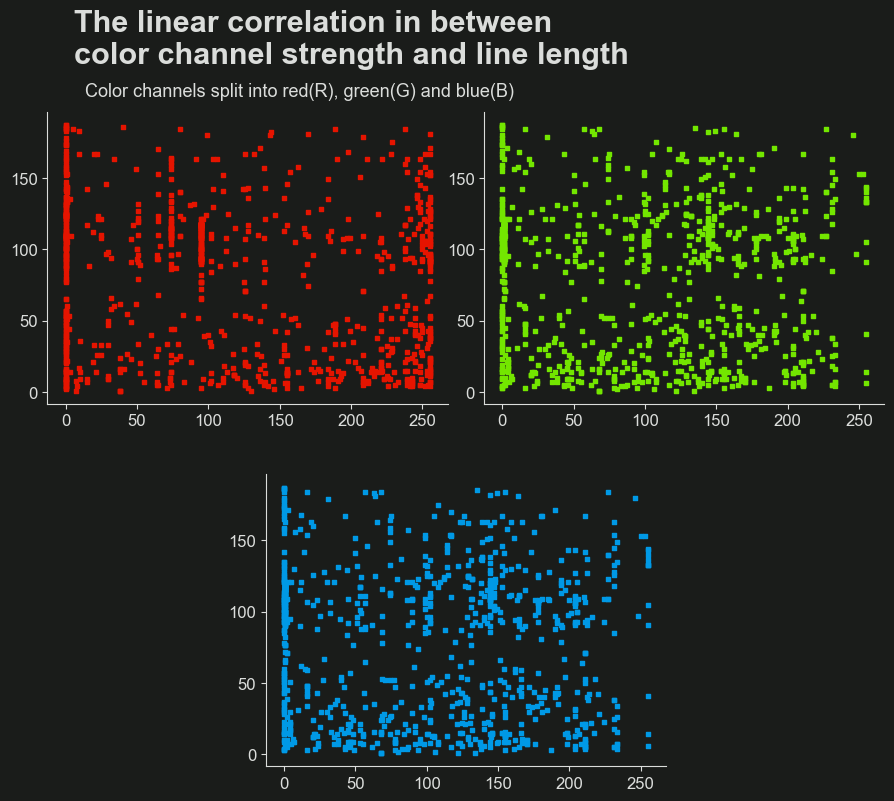

In [134]:
# --- data prep ---
data = result
datasets = [data.loc[:, [colname, "age"]].rename({colname: "colvalue"}, axis=1) for colname in ["r_value", "g_value", "b_value"]]

# get the data into a format that is more suitable for iterative plotting
fig_titles = ["R channel value", "G channel value", "B channel value"]
colors = ["#E51400", "#73E600", "#0099E6"] # MAKE THIS INTO GRADIENTS
correlations = []

# --- viz setup ---
# create figure
fig = plt.figure(figsize = (10.80, 10.80),
                 dpi = 100)
spec = fig.add_gridspec(ncols=4, nrows=2, hspace=-0.2)
ax_positions = [spec[0, :2], spec[0, 2:], spec[1, 1:3]]
for ax_position in ax_positions:
    ax = fig.add_subplot(ax_position, aspect=1)


# configure params
# titles
plt.figtext(s="The linear correlation in between\ncolor channel strength and line length",
          x=0.15,
          y=0.85,
          va="baseline",
          ha="left",
          fontsize=22,
          fontweight="bold")

plt.figtext(s="Color channels split into red(R), green(G) and blue(B)",
             x=0.16,
             y=0.82,
             va="baseline",
             ha="left",
             fontsize=13,
             fontweight="normal")

for ax, dataset, fig_title, color in zip(fig.axes, datasets, fig_titles, colors):
# spines and axes
    for spine in ["right", "top"]:
        ax.spines[spine].set_visible(False)

# axis labels

# --- plotting ---
    ax.scatter(dataset["colvalue"], dataset["age"],
               s=10, c=color, marker="s")


#### Question ten

> ***What is the most popular line color for each country?***

##### English explanation

###### SQL explanation
Join the cities table with the lines table. Select each country from the cities table that appears more than twice in the "lines" table. This is used to filter out countries that have less than three distinctly colored transportation lines recorded in the database. Select color of the each line to represent the lines. Group by country first, then by color. Calculate how many times each color occurs within its country group, name this as "occurence_count"

###### Python explanation
We read the SQL table we get into a dataframe. To make our dataframe more intelligible, we first convert "occurence_count" to a percentage. Then we filter the dataframe to get only the most recurring color.
In the end, we have a dataframe of countries, their most popular line color and its occurence percentage.

##### Code

In [87]:
sql_query = """
SELECT x.country, z.color, COUNT(z.color) AS occurence_count
  FROM (SELECT c.country, COUNT(c.country)
          FROM cities c
               JOIN `lines` l ON (c.id = l.city_id)
         GROUP BY c.country
         HAVING COUNT(c.country) > 2) x
        JOIN cities y ON (x.country = y.country)
        JOIN `lines` z on (y.id = z.city_id)
 GROUP BY x.country, z.color
 ORDER BY x.country ASC, occurence_count DESC;
"""

result = pd.read_sql(sql_query, conn)

# The result needs further processing
perc = (result.groupby(["country"])["occurence_count"].max()
        / result.groupby(["country"])["occurence_count"].sum()*100) # Get the percentage versions
perc = pd.DataFrame(perc).reset_index()
max_mask = result.groupby("country")["occurence_count"].transform(max) == result["occurence_count"] # Select the max only
result = (result.loc[max_mask, :]
          .sort_values("country", ascending=True))
result = pd.merge(result, perc, on="country")
result = (result
          .drop("occurence_count_x", axis=1)
          .rename({"occurence_count_y": "occurence_perc"}, axis=1))
result


,country,color,occurence_perc
0,Argentina,#f3d379,42.857143
1,Australia,#000,48.888889
2,Austria,#000,55.000000
3,Belgium,#e5442e,13.636364
4,Belgium,#eabc00,13.636364
...,...,...,...
75,Singapore,#748477,33.333333
76,Spain,#159585,12.000000
77,Sweden,#bd10e0,25.000000
78,Sweden,#7ed321,25.000000


##### Interpretation of results

Visualizing the results and then interpreting them would serve the purpose of answering our question better than looking at only raw data.

###### Visualization
The code responsible for creating the visualization has been collapsed for ease of reading.

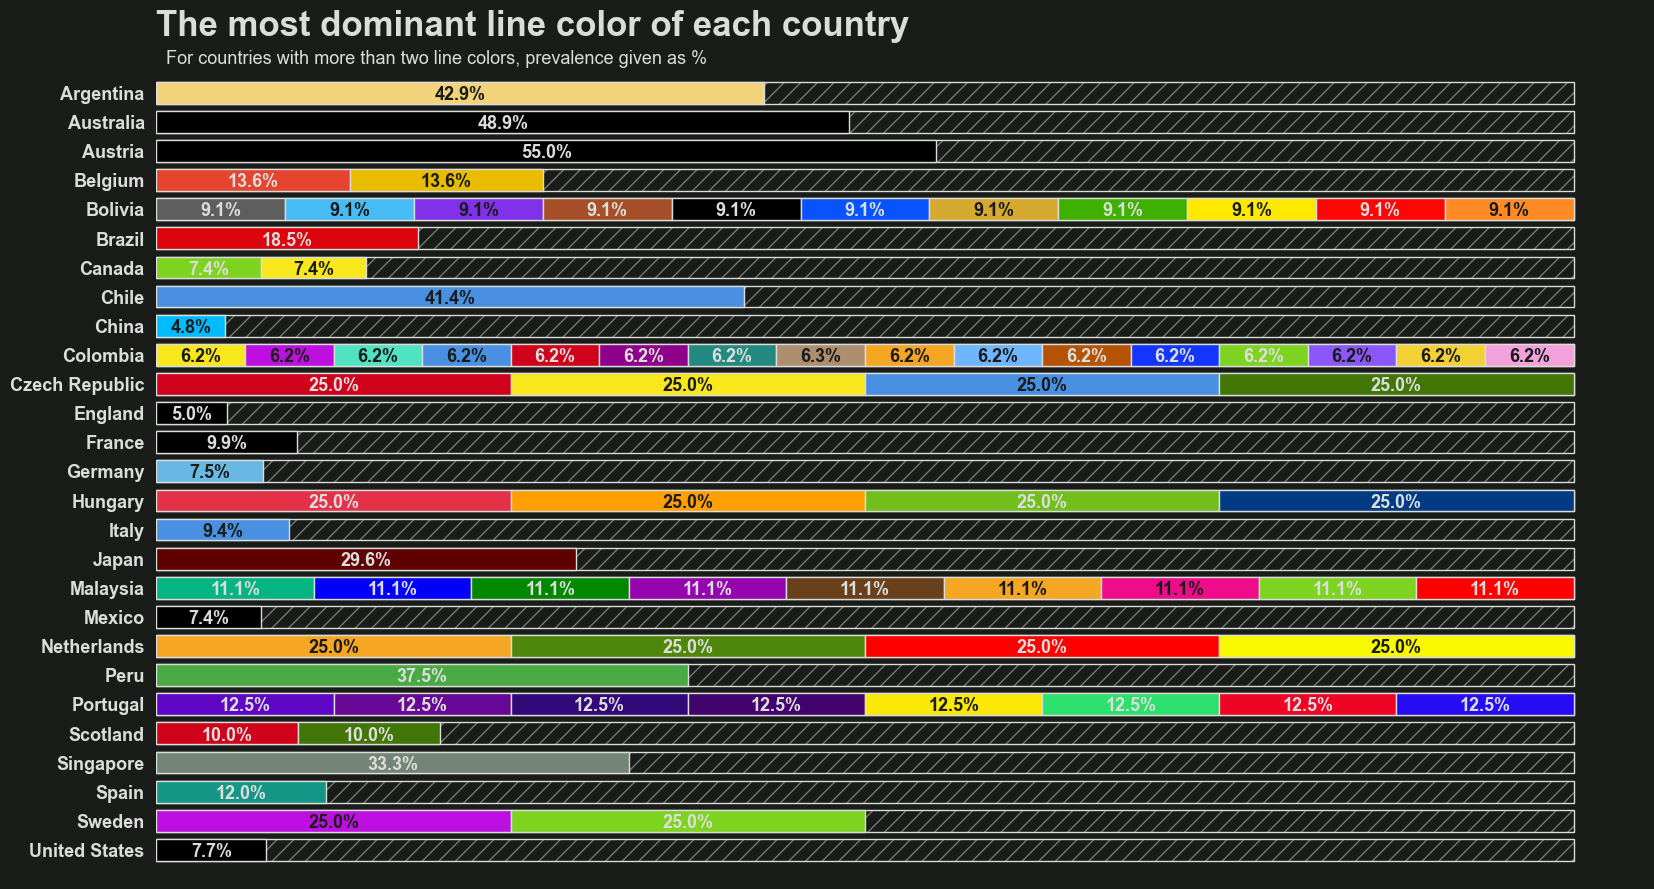

In [88]:
# --- data prep ---
data = result

# get the data into a format that is more suitable for iterative plotting
data_levels = []
data_levels.append(data)
i = 0
while sum(data_levels[i]["country"].duplicated()):
    mask = data_levels[i]["country"].duplicated()
    data_levels.append(data_levels[i].loc[mask, :])
    data_levels[i] = data_levels[i].loc[~mask, :]
    i += 1

unique_countries = sorted(set(data_levels[0]["country"].values))

# save the position of each unique country
positions = {}
i = 0
j = 0
while i < len(unique_countries):
    positions[unique_countries[i]] =  j
    j += 1
    i += 1

# prepare base plot (gray bars at 100 length) data
bar_labels = unique_countries
bar_positions = [positions[name] for name in bar_labels]
bar_widths = [100 for label in bar_labels]

# --- viz setup ---
# create figure
fig = plt.figure(figsize = (19.20, 10.80),
                 dpi = 100)
ax = fig.add_subplot(1, 1, 1)

# configure params
# spines and axes
for spine in ["left", "right", "top", "bottom"]:
    ax.spines[spine].set_visible(False)
ax.invert_yaxis()
ax.axes.set_ylim(27, -1)

# ticks and labels
ax.set_yticks(bar_positions)
ax.set_yticklabels(bar_labels,
                   fontsize=13,
                   fontweight = "bold")

ax.set_xticks([])
ax.set_xticklabels([])

ax.tick_params(axis = "both",
    which = "both",
    bottom = False,
    top = False,
    left = False,
    right = False,
    pad = 5)

# --- plotting ---
# write the title 
plt.title("The most dominant line color of each country",
          fontdict={'fontsize': 25,
                   'fontweight' : "bold",
                   'verticalalignment': 'baseline',
                   'horizontalalignment': "left"},
          loc="left",
          pad=20)

plt.suptitle('For countries with more than two line colors, prevalence given as %',
             x=0.13,
             y=0.88,
             va="baseline",
             ha="left",
             fontsize=13)

# plot the base figure without hatches
ax.barh(y = bar_positions,
        width = bar_widths,
        color = "#FFFFFF00",
        hatch = "//",
        align = "center",
        height = 0.75,
        edgecolor = "#757875",
        linewidth = 0)

# plot the base figure with hatches
ax.barh(y = bar_positions,
        width = bar_widths,
        color = "#FFFFFF00",
        align = "center",
        height = 0.75,
        edgecolor = "#DBDDDB",
        linewidth = 1)

# plot the stacked bar charts iteratively
i = 0
left_widths = data_levels[0].loc[:, ["country", "occurence_perc"]]
while i < len(data_levels):
    data_level = data_levels[i]
    bar_widths = data_level["occurence_perc"].values
    bar_labels = sorted(data_level["country"].values)
    opposite_mask = left_widths.loc[:, "country"].isin(data_level["country"])

    left_start = left_widths.loc[opposite_mask, "occurence_perc"].values if i > 0 else 0

    if i > 0:
        left_widths.loc[opposite_mask, "occurence_perc"] += bar_widths

    bar_positions = [positions[name] for name in bar_labels]
    bar_colors = data_level["color"]

    bar = ax.barh(y = bar_positions,
            height = 0.75,
            width = bar_widths,
            left = left_start,
            color = bar_colors,
            align = "center",
            edgecolor = "#DBDDDB",
            linewidth = 1)

    add_value_labels_barh(ax, bar,
                          l_prefix="", l_suffix="%",
                          fontsize=13, fontweight="bold", fcolors=["#DBDDDB", "#1A1C1A"],
                          ha="center", va="center_baseline", rotation="0")
    i += 1


###### Interpretation

The visualization above displays the most dominant line color for 27 of the countries present in the 'city-lines' dataset. These 27 countries are a subset of the total countries that are represented in the dataset because only countries that have more than two distinct line colors have been included in the analysis. **In the visualization, each colored segment of the vertical bars gives information about what the dominant line color is for the country that it matches with.** The segments are annotated with the percentage by which they are dominant. The un-colored, textured portions of the vertical bars stand for the rest of the color distribution.

The first thing that is apparent from the visualization is the fact that there are many unique colors that stand as the most dominant line colors of their countries. Colors such as **red, yellow, green and black** are well-represented in the dataset. However, more unusual colors like **maroon, teal and pink are also present as 'top' colors.** The percentage by which a color stands as the most utilized line color also differs highly: the most used line colors of some countries such as China and England are popular only by 4.8% and 5.0% respectively whereas in contrast the top color of Austria is prevalent by an overwhelming 55.0%

Another occurence that is highlighted in the visualization is the fact that **not all countries have only one color as it's most dominant color.** There are many countries that have two or more colors with the same prevalence, such as Belgium (two colors), Sweden (two colors) and Colombia (16 colors.)